In [1]:
import os
import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["figure.facecolor"] = "white"

# helpers
from utils import get_contours_from_segmasks, get_contour_stats


# 2024_0312_200610_055_trimmed_10sec_ts76-te86_cropped_200-850-0-600.mp4

In [2]:
df = pd.read_csv("./data/videos/moss/moss-corona-dataset.csv")
print("n_clips = ", len(df), "\ntotal_duration (sec) = ", df["duration"].sum())
cidx = 6
print(df.loc[cidx, "save_filename"])
df

# options: 2024_0312_200610_055_trimmed_10sec_ts76-te86_cropped_200-850-0-600.mp4 index = 6
# 2024_0311_153344_021_trimmed_5sec_ts0-te5_cropped_1200-1750-1000-2000.mp4 index=8

n_clips =  19 
total_duration (sec) =  170
2024_0311_153344_021_trimmed_5sec_ts0-te5_cropped_1200-1750-1000-2000.mp4


,filename,tstart,tend,desc,fps,width,height,duration,x1,x2,y1,y2,save_filename
0,2024_0312_200031_053,74,89,extent from contraction,24,2880,2160,15,250,1250,0,1100,2024_0312_200031_053_trimmed_15sec_ts74-te89_c...
1,2024_0312_200250_054,0,14,extent from contraction,24,2880,2160,14,250,1250,0,1100,2024_0312_200250_054_trimmed_14sec_ts0-te14_cr...
2,2024_0312_200250_054,118,128,extent from contraction,24,2880,2160,10,250,1250,0,1100,2024_0312_200250_054_trimmed_10sec_ts118-te128...
3,2024_0312_200610_055,32,42,extent from contraction,60,1920,1080,10,200,850,0,600,2024_0312_200610_055_trimmed_10sec_ts32-te42_c...
4,2024_0312_200610_055,121,131,extent from contraction,60,1920,1080,10,200,850,0,600,2024_0312_200610_055_trimmed_10sec_ts121-te131...
5,2024_0312_084233_028,125,135,extent from contraction,24,2880,2160,10,800,1800,500,1500,2024_0312_084233_028_trimmed_10sec_ts125-te135...
6,2024_0311_153344_021,0,5,extent from contraction,24,2880,2160,5,1200,1750,1000,2000,2024_0311_153344_021_trimmed_5sec_ts0-te5_crop...
7,2024_0312_200250_054,85,95,retraction,24,2880,2160,10,250,1250,0,1100,2024_0312_200250_054_trimmed_10sec_ts85-te95_c...
8,2024_0312_200610_055,76,86,retraction,60,1920,1080,10,200,850,0,600,2024_0312_200610_055_trimmed_10sec_ts76-te86_c...
9,2024_0311_153344_021,414,417,retraction,24,2880,2160,3,800,1900,650,1400,2024_0311_153344_021_trimmed_3sec_ts414-te417_...


In [3]:
# Video folder
vid_dir = "videos/moss"
vid_path = f"./data/{vid_dir}/"

# Video
vid_filename = df.loc[cidx, "save_filename"]
vid_extension = "." + vid_filename.split(".")[-1]
vid_filename = vid_filename.split(".")[0]
vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"

# Masks
seg_mask_folder_name = "seg_mask_folder"
seg_mask_path = f"{vid_path}/{seg_mask_folder_name}/{vid_filename}_masks"

# Image Frames
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5

# Results
save_figure_path = f"{vid_path}/results/{vid_filename}"
os.makedirs(save_figure_path, exist_ok=True)

# Params
fps = df.loc[cidx, "fps"]
width = df.loc[cidx, "width"]
height = df.loc[cidx, "height"]
resolution = (height,width)

print(fps, resolution)

# DF STUFF
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
segmentation_mask_filepaths = df["mask_fpath"].tolist()

#frame_idx = 163 # 128
#contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:frame_idx])
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths)

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
#df = df[:frame_idx]
num_frames = len(df)
print("num_frames:", num_frames)
#df.head(5)

24 (2160, 2880)
num_frames: 120 ; save_figure_path: ./data/videos/moss//results/2024_0311_153344_021_trimmed_5sec_ts0-te5_cropped_1200-1750-1000-2000 ; fps: 24 ; resolution: (2160, 2880)
UHD, pixel_per_real_width =  0.4
num_frames: 120


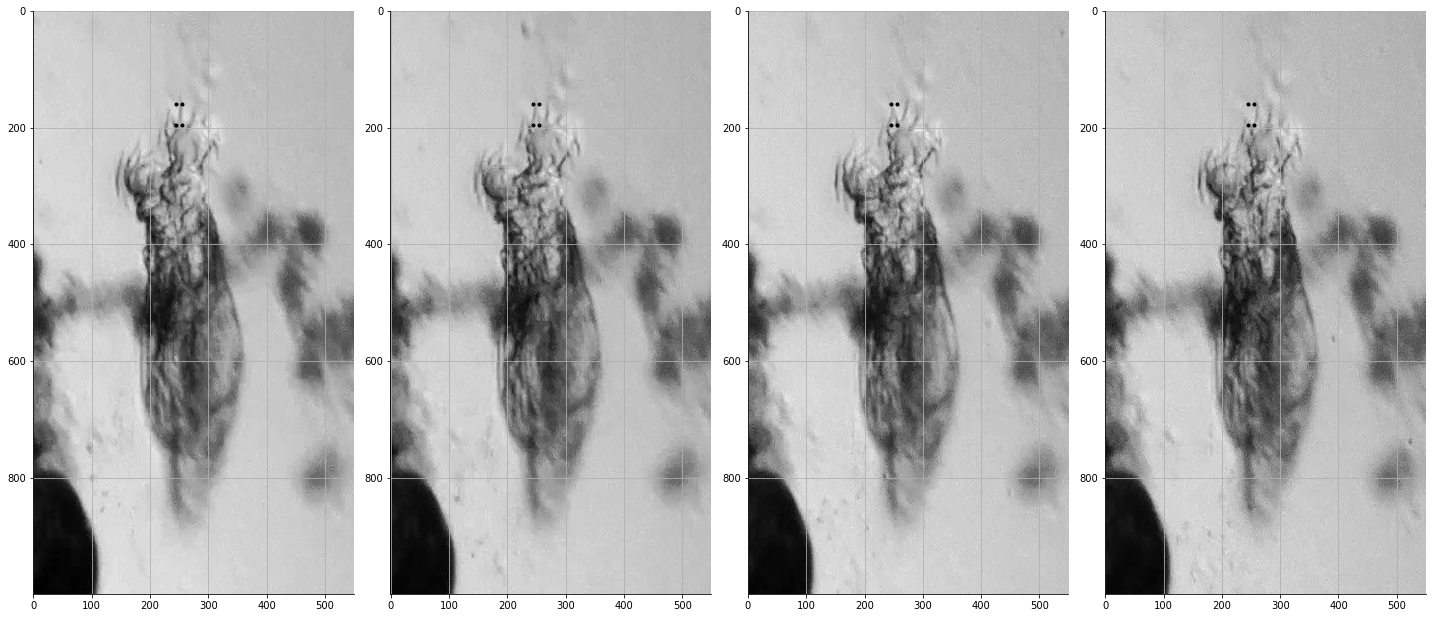

In [7]:
plt.rcParams['figure.facecolor'] = 'white'

bbox = [245,255,160,195]  # x1,x2,y1,y2
cidx_ = np.arange(30, 70, 10)

fig, ax = plt.subplots(1, len(cidx_), figsize=(20,20), layout="tight")

for nth, i in enumerate(cidx_):
    cimg = cv2.cvtColor(cv2.imread(df.loc[i, "img_fpath"], 1), cv2.COLOR_BGR2GRAY)
    ax[nth].imshow(cimg, cmap="gray")
    ax[nth].plot([bbox[0], bbox[1], bbox[1], bbox[0]],[bbox[2], bbox[3], bbox[2], bbox[3]], ".k")
    ax[nth].grid(True)
    
# mask out the bbox region! use eg bitwise_or

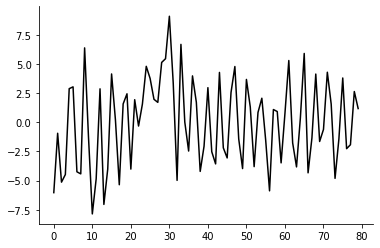

In [8]:
cidx = 30 # 70
cimg = cv2.cvtColor(cv2.imread(df.loc[cidx, "img_fpath"], 1), cv2.COLOR_BGR2GRAY) #  cv2.COLOR_BGR2RGB)
pixel_values = []

bbox = [245,255,160,195]  # x1,x2,y1,y2
cidx_ = np.arange(30, 110, 1)
for nth, i in enumerate(cidx_):
    cimg = cv2.cvtColor(cv2.imread(df.loc[i, "img_fpath"], 1), cv2.COLOR_BGR2GRAY)
    pixel_values.append(cimg[bbox[2]:bbox[3], bbox[0]:bbox[1]])

avg_pix = []
yavg_pix = []

for px in pixel_values:
    avg_pix.append(np.mean(px))

avg_pix = np.array(avg_pix) - np.mean(avg_pix)

plt.plot(avg_pix, "-k")

24


Text(0, 0.5, 'Power')

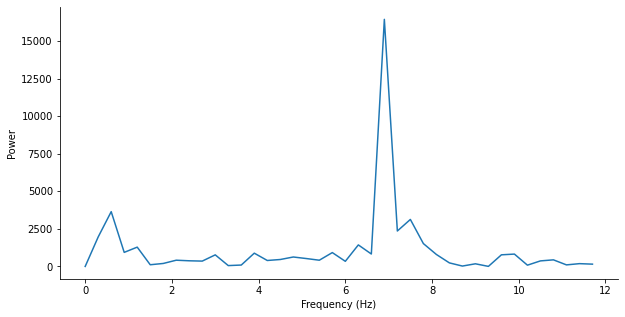

In [9]:
sampling_rate = fps  # Hz
print(sampling_rate)

fft_result = np.fft.fft(avg_pix)
freqs = np.fft.fftfreq(len(avg_pix), d=1/sampling_rate)
power_spectrum = np.abs(fft_result)**2

plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(avg_pix)//2], power_spectrum[:len(avg_pix)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# 2024_0312_200610_055_trimmed_10sec_ts76-te86_cropped_200-850-0-600.mp4

In [11]:
df = pd.read_csv("./data/videos/moss/moss-corona-dataset.csv")
print("n_clips = ", len(df), "\ntotal_duration (sec) = ", df["duration"].sum())
cidx = 8
print(df.loc[cidx, "save_filename"])
df

# Video folder
vid_dir = "videos/moss"
vid_path = f"./data/{vid_dir}/"

# Video
vid_filename = df.loc[cidx, "save_filename"]
vid_extension = "." + vid_filename.split(".")[-1]
vid_filename = vid_filename.split(".")[0]
vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"

# Masks
seg_mask_folder_name = "seg_mask_folder"
seg_mask_path = f"{vid_path}/{seg_mask_folder_name}/{vid_filename}_masks"

# Image Frames
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5

# Results
save_figure_path = f"{vid_path}/results/{vid_filename}"
os.makedirs(save_figure_path, exist_ok=True)

# Params
fps = df.loc[cidx, "fps"]
width = df.loc[cidx, "width"]
height = df.loc[cidx, "height"]
resolution = (height,width)

print(fps, resolution)

# DF STUFF
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
segmentation_mask_filepaths = df["mask_fpath"].tolist()

#frame_idx = 163 # 128
#contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:frame_idx])
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths)

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
#df = df[:frame_idx]
num_frames = len(df)
print("num_frames:", num_frames)
#df.head(5)

n_clips =  19 
total_duration (sec) =  170
2024_0312_200610_055_trimmed_10sec_ts76-te86_cropped_200-850-0-600.mp4
60 (1080, 1920)
num_frames: 600 ; save_figure_path: ./data/videos/moss//results/2024_0312_200610_055_trimmed_10sec_ts76-te86_cropped_200-850-0-600 ; fps: 60 ; resolution: (1080, 1920)
FHD, pixel_per_real_width =  0.61
num_frames: 600


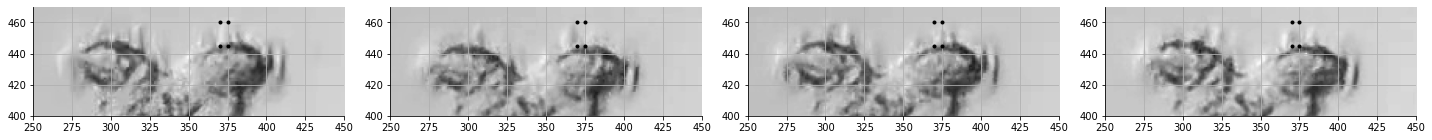

In [15]:
plt.rcParams['figure.facecolor'] = 'white'

bbox = [370, 375, 445, 460]  # x1,x2,y1,y2
cidx_ = np.arange(0, 120, 30)
zxlim = [250, 450]; zylim = [400, 470]

fig, ax = plt.subplots(1, len(cidx_), figsize=(20,20), layout="tight")

for nth, i in enumerate(cidx_):
    cimg = cv2.cvtColor(cv2.imread(df.loc[i, "img_fpath"], 1), cv2.COLOR_BGR2GRAY)
    ax[nth].imshow(cimg, cmap="gray")
    ax[nth].set_xlim(zxlim); ax[nth].set_ylim(zylim)
    ax[nth].plot([bbox[0], bbox[1], bbox[1], bbox[0]],[bbox[2], bbox[3], bbox[2], bbox[3]], ".k")
    ax[nth].grid(True)
    
# mask out the bbox region! use eg bitwise_or

60


Text(0, 0.5, 'Power')

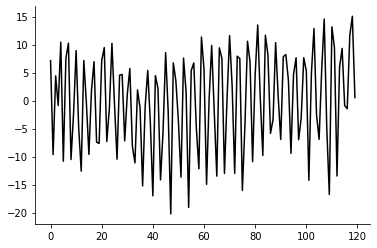

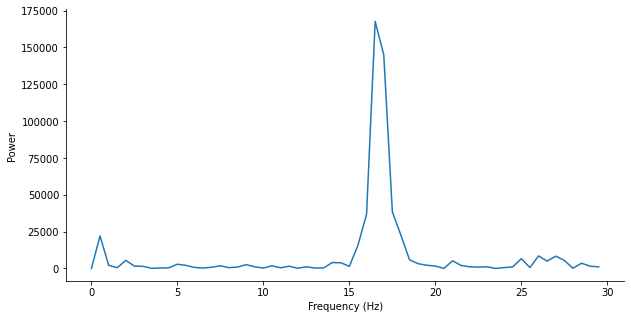

In [18]:
pixel_values = []

bbox = [370, 375, 445, 460] 
cidx_ = np.arange(0, 120, 1)
for nth, i in enumerate(cidx_):
    cimg = cv2.cvtColor(cv2.imread(df.loc[i, "img_fpath"], 1), cv2.COLOR_BGR2GRAY)
    pixel_values.append(cimg[bbox[2]:bbox[3], bbox[0]:bbox[1]])

avg_pix = []
yavg_pix = []

for px in pixel_values:
    avg_pix.append(np.mean(px))

avg_pix = np.array(avg_pix) - np.mean(avg_pix)

plt.plot(avg_pix, "-k")

sampling_rate = fps  # Hz
print(sampling_rate)

fft_result = np.fft.fft(avg_pix)
freqs = np.fft.fftfreq(len(avg_pix), d=1/sampling_rate)
power_spectrum = np.abs(fft_result)**2

plt.figure(figsize=(10, 5))
#plt.plot(freqs[:len(avg_pix)], power_spectrum[:len(avg_pix)])
plt.plot(freqs[:len(avg_pix)//2], power_spectrum[:len(avg_pix)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')